# Regression on Kernel Integrals

In [1]:
# Import preliminary libraries
import numpy as np
from numpy.fft import fft, fftshift
import pandas as pd
import matplotlib.pyplot as plt
from NMR_ML import Dataset, PolynomialFeatures, FeatureImportancePlot, FourierTransform

In [2]:
# Create a dataset object for the gaussian kernel type simulation and load all data

gaus = Dataset(data_directory_path="../../work/data/2021-08-14_gauss/")
rawdata = gaus.load_data()
params = gaus.load_params()
kers = gaus.load_wlist()   # we perform regression on this variable
y_classes  = gaus.get_yclasses()
rscl_df, _ = gaus.get_window(rawdata, center_ratio=2/3, width=150)

Finished loading rawdata into numpy array
Finished loading parameters file
Finished loading kernel-integrals file.
Finished loading parameters file
Finished loading kernel-integrals file.
The Echo pulse occurs at timestep: 1256


In [3]:
# Kernel integrals dataset
kers.head()

,0
0,0.114080
1,0.165097
2,0.115453
3,0.127511
4,0.156341


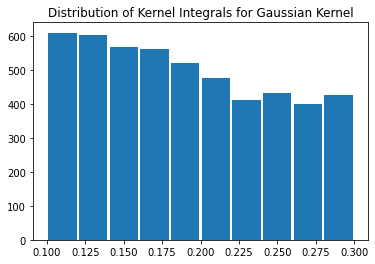

In [4]:
plt.hist(kers.values.ravel(), rwidth=0.92)
plt.title("Distribution of Kernel Integrals for Gaussian Kernel")
plt.show()

In [5]:
# Convert the rescaled-dataframe to a numpy array and verify shape
rscl_df.to_numpy().shape

(5000, 300)

In [6]:
# Fourier transform data
ft_data, fx_data = FourierTransform(zero_padding=8).transform(rscl_df.to_numpy())

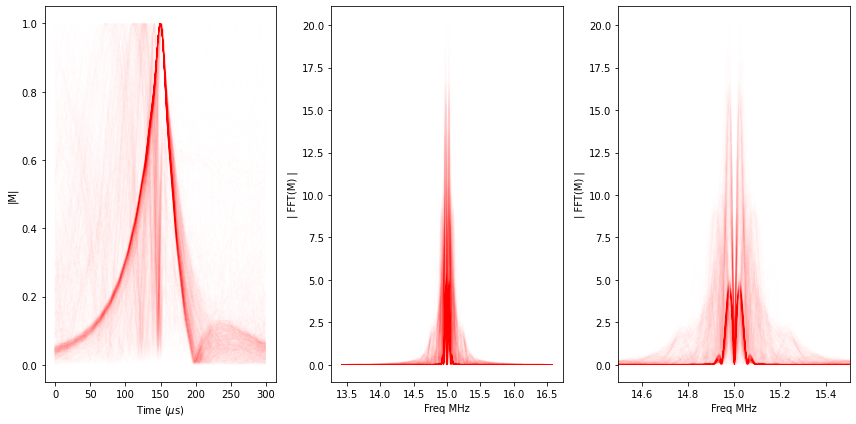

In [7]:
# Plot to visualize the different datasets
fig, ax = plt.subplots(1,3, figsize=(12,6))

# we plot every 5th datapoint
ax[0].plot(rscl_df.to_numpy()[::5].T, alpha=0.002, color='red')
ax[0].set(xlabel='Time ($\mu$s)', ylabel='|M|')

ax[1].plot(15 + fx_data[::5].T, ft_data[::5].T, alpha=0.002, color='red')
ax[1].set(xlabel='Freq MHz', ylabel="| FFT(M) |")

ax[2].plot(15 + fx_data[::5].T, ft_data[::5].T, alpha=0.002, color='red')
ax[2].set(xlabel='Freq MHz', ylabel="| FFT(M) |", xlim=[15-0.5, 15+0.5] )

plt.tight_layout()
plt.show()

# Polynomial Feature extraction from timeseries and Frequency-bins

In [8]:
# Create the Polynomial_features object and extract features for the timeseries and freqeuency domain datasets

pf = PolynomialFeatures(n_splits=[4, 5, 10], order_fits=[3, 3, 3])
%time ts_pf = pf.extract(rscl_df.to_numpy())

# we choose only 800 values for the frequency domain 
# so that the length of the array is 800
# and it is easier to split into (4,5,10) equal halves

%time fs_pf = pf.extract(ft_data[:, 6:-6])  

CPU times: user 8.39 s, sys: 3.82 ms, total: 8.39 s
Wall time: 8.39 s
CPU times: user 8.87 s, sys: 7.89 ms, total: 8.88 s
Wall time: 8.87 s


In [9]:
# Rescaled time window of interest
rscl_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,0.046998,0.047899,0.048976,0.050135,0.051244,0.052152,0.052715,0.052829,0.052453,0.051630,...,0.076163,0.073727,0.071628,0.069927,0.068620,0.067656,0.066954,0.066416,0.065942,0.065440
1,0.033260,0.032670,0.032096,0.031726,0.031692,0.032041,0.032729,0.033647,0.034668,0.035671,...,0.009927,0.009936,0.010065,0.010292,0.010670,0.011258,0.012027,0.012833,0.013472,0.013761
2,0.036057,0.035182,0.034550,0.034317,0.034548,0.035204,0.036165,0.037262,0.038330,0.039254,...,0.051485,0.050636,0.049978,0.049500,0.049118,0.048694,0.048080,0.047161,0.045886,0.044295
3,0.046061,0.047268,0.048244,0.048961,0.049426,0.049685,0.049820,0.049934,0.050135,0.050511,...,0.035593,0.034321,0.032943,0.031631,0.030542,0.029780,0.029382,0.029326,0.029558,0.030009
4,0.048227,0.049512,0.050739,0.051835,0.052745,0.053455,0.053991,0.054416,0.054804,0.055227,...,0.039747,0.038892,0.038193,0.037767,0.037657,0.037831,0.038193,0.038614,0.038968,0.039153


In [10]:
# Polynomial features for timeseries
ts_pf.head()

,4_1_3,4_1_2,4_1_1,4_1_0,4_2_3,4_2_2,4_2_1,4_2_0,4_3_3,4_3_2,...,10_8_1,10_8_0,10_9_3,10_9_2,10_9_1,10_9_0,10_10_3,10_10_2,10_10_1,10_10_0
0,-2.803564e-07,0.000014,0.001829,0.083943,1.892147e-06,0.000163,0.008879,0.360918,-5.586193e-08,0.000307,...,0.002309,0.083844,7.849371e-07,-0.000016,-0.000236,0.095559,-3.413139e-07,-0.000046,-0.000825,0.083165
1,1.416806e-07,0.000019,0.001632,0.069931,9.861831e-07,0.000134,0.010010,0.407446,-1.012685e-06,0.000165,...,-0.003856,0.075882,-1.610505e-06,0.000007,-0.000914,0.015629,2.210606e-06,-0.000014,-0.000039,0.011011
2,1.834305e-07,0.000006,0.001375,0.079726,1.483040e-06,0.000138,0.009670,0.387276,-1.278877e-07,0.000251,...,0.001863,0.051793,2.125097e-06,0.000012,-0.000798,0.058366,-3.641176e-06,-0.000021,0.000376,0.051556
3,-3.027449e-08,0.000026,0.001742,0.077971,1.312491e-06,0.000133,0.009490,0.404720,-1.389840e-06,0.000192,...,-0.001103,0.009640,1.053047e-07,-0.000058,0.000665,0.042560,1.433586e-06,-0.000008,-0.000810,0.038228
4,8.582691e-08,0.000025,0.001638,0.081954,1.256443e-06,0.000145,0.009451,0.395299,-9.384739e-07,0.000216,...,0.002390,0.015731,2.757922e-06,-0.000019,-0.000288,0.056697,9.078677e-07,0.000037,-0.000885,0.042304


In [11]:
# Polynomial features for freqeuency data
fs_pf.head()

,4_1_3,4_1_2,4_1_1,4_1_0,4_2_3,4_2_2,4_2_1,4_2_0,4_3_3,4_3_2,...,10_8_1,10_8_0,10_9_3,10_9_2,10_9_1,10_9_0,10_10_3,10_10_2,10_10_1,10_10_0
0,5.305816e-11,7.920075e-09,9.548555e-07,0.000069,0.000002,0.000121,-0.007634,-0.200335,-2.028896e-06,0.000110,...,-5.004408e-06,0.000294,-9.537441e-11,8.518103e-09,-1.239484e-06,0.000095,-5.575541e-12,8.046966e-10,-5.607649e-07,0.000026
1,-8.727785e-12,2.815602e-10,4.485928e-08,0.000005,0.000001,0.000056,-0.003527,-0.093192,-9.401634e-07,0.000051,...,5.717774e-09,0.000006,-1.468560e-10,3.665535e-09,1.316385e-07,0.000004,3.043155e-11,5.109008e-09,4.666406e-08,0.000004
2,1.336098e-11,3.593627e-09,5.523937e-07,0.000126,0.000002,0.000114,-0.007220,-0.190036,-1.914595e-06,0.000104,...,-2.049469e-06,0.000242,-5.894017e-10,3.110621e-09,-3.147838e-07,0.000138,-4.411538e-10,2.628520e-09,1.086743e-07,0.000104
3,3.955099e-15,-6.746950e-10,2.718780e-09,0.000009,0.000002,0.000095,-0.006016,-0.159020,-1.596490e-06,0.000087,...,3.464198e-08,0.000003,3.361534e-10,5.643647e-09,-3.231713e-07,0.000005,-7.307463e-12,-4.860661e-11,-9.676159e-08,0.000006
4,4.802173e-12,1.166416e-09,2.205905e-07,0.000019,0.000002,0.000106,-0.006734,-0.177403,-1.784376e-06,0.000097,...,-7.038412e-07,0.000059,-1.221847e-10,5.230616e-10,-1.896640e-07,0.000024,-7.853213e-11,3.638288e-09,-9.268774e-08,0.000007


# Random Forest Model 

- We employ a random forest model to perform regression on the kernel-integral weights based on the magentization data alone.

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [13]:
def get_R2(x_data, y_data):
    score = []
    for i in range(5):
        x_train, x_test ,y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=10+10*i)
        model = RandomForestRegressor(n_estimators=100, max_features="sqrt", n_jobs=-1)
        model.fit(x_train, y_train.values.ravel())
        score.append(model.score(x_test, y_test))
    
    return model, score, model.predict(x_test), y_test

In [14]:
m1, score1, y_pred1, y_test1 = get_R2(rscl_df, kers)
m2, score2, y_pred2, _ = get_R2(ts_pf, kers)
m3, score3, y_pred3, _ = get_R2(pd.DataFrame(ft_data), kers)
m4, score4, y_pred4, _ = get_R2(fs_pf, kers)

In [15]:
mean = list(map(np.mean, [score1, score2, score3, score4]))
std = list(map(np.std, [score1, score2, score3, score4]))

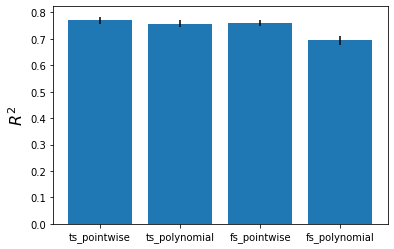

In [16]:
fig,ax = plt.subplots()
ax.bar(x=np.arange(4), height=mean, yerr=std)

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["ts_pointwise", "ts_polynomial", "fs_pointwise", "fs_polynomial"])
ax.set_ylabel('$R^2$', fontsize=16)
plt.show()

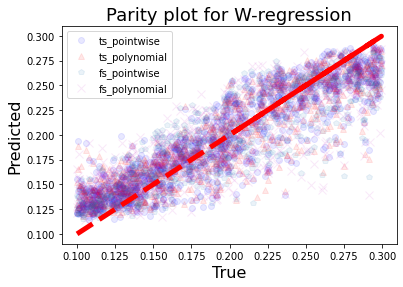

In [17]:
# Parity Plot

plt.plot(y_test1, y_pred1, 'bo', alpha=0.09, label='ts_pointwise')
plt.plot(y_test1, y_pred2, 'r^', alpha=0.09, label='ts_polynomial')
plt.plot(y_test1, y_pred3, 'p', alpha=0.09, label='fs_pointwise')
plt.plot(y_test1, y_pred4, 'mx',markersize=8, alpha=0.09, label='fs_polynomial')

plt.plot(y_test1, y_test1, 'r--', lw=5)

plt.ylabel("Predicted", fontsize=16)
plt.xlabel("True", fontsize=16)
plt.title("Parity plot for W-regression", fontsize=18)
plt.legend()

plt.show()

## Feature Importance plots

In [18]:
help(FeatureImportancePlot)

Help on class FeatureImportancePlot in module NMR_ML:

class FeatureImportancePlot(builtins.object)
 |  FeatureImportancePlot(length_tseries: int, n_splits: list, kind: str)
 |  
 |  A FeatureImportancePlot class represents a matplotlib axes plot that
 |  plots the features from polynomial feature extraction based on the
 |  feature importances from a random forest model.
 |  
 |  Attributes:
 |  ----------
 |  length_tseries: int
 |      The length of the time-series that the polynomial feaures works on
 |  
 |  n_splits: list
 |      A list of integers that specifies that number of equal partitions
 |      the dataset has to be bifurcated into.
 |  
 |  kind: str ("timeseries"  or "polyfeatures" )
 |      The kind of dataset used by the random forest model for learning
 |      the classification/regression parameters.
 |  
 |  Methods:
 |  --------
 |  get_intervals() -> np.ndarray
 |      Returns the end-points or intervals of a n-fold
 |      (FeatureImportancePlot.n_splits) partit

In [19]:
# Here we plot the feature importance plot form the timeseries data

fip = FeatureImportancePlot(length_tseries=300, n_splits=[4,5,10], kind='polyfeatures')
fi_df = fip.get_fi(m2, ts_pf)
fi_df.head(10)

,feature,fi,order,color
10,4_3_1,0.066555,1,b
58,10_6_1,0.055549,1,b
19,5_1_0,0.053929,0,r
26,5_3_1,0.048027,1,b
3,4_1_0,0.046260,0,r
25,5_3_2,0.040335,2,g
27,5_3_0,0.039368,0,r
43,10_2_0,0.035002,0,r
23,5_2_0,0.032190,0,r
75,10_10_0,0.032128,0,r


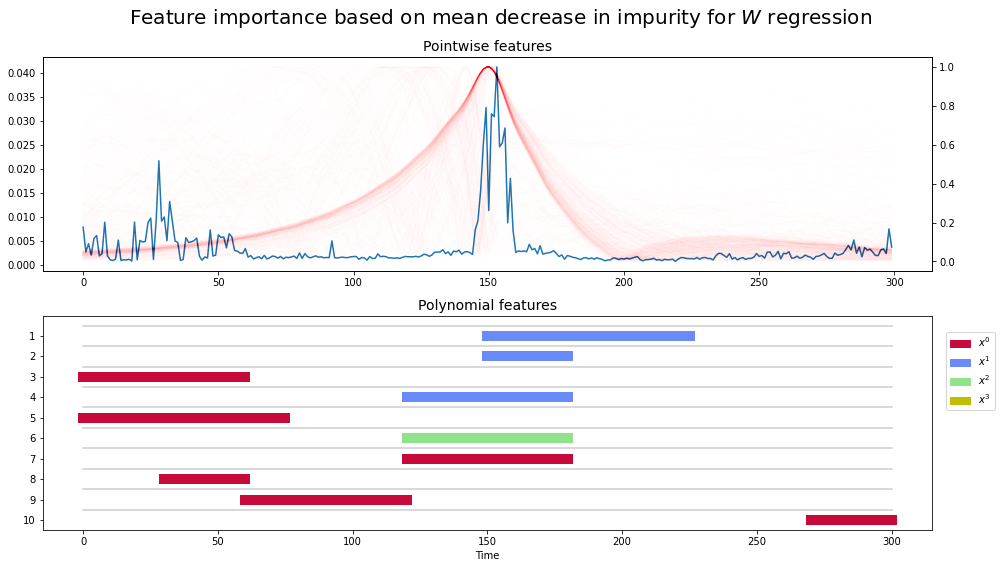

In [20]:
# Play with the top features required
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,8))

ntop=10

ax1.plot(m1.feature_importances_, label='Feature importance')
ax1.set_title("Pointwise features", fontsize=14)

# Plot the echo curve for reference
ax1_echocopy = ax1.twinx()
ax1_echocopy.plot(rscl_df.to_numpy()[::10].T, alpha=0.002, color='red', label='Echo curves')


ax2.set_title("Polynomial features", fontsize=14)
fip.fi_df2plot(fi_df, ntop=ntop, ax=ax2)

plt.suptitle("Feature importance based on mean decrease in impurity for $W$ regression", fontsize=20)
plt.tight_layout()

plt.show()

### Feature Importance plot analysis: 

1. The most significant features from both the datasets (pointwise and polynomial) correspond to similar points on the echo-curves. 
2. The predominant regions in the echo-window seem to the timestamp just at the echo-pulse and the pre-echo region. We need to study the feature importances for other functional forms (RKKY, Power law) and investigate how the feature importances change for those curves. Since the Gaussian and RKKY kinds correspond to short-range interactions, we might expect differences between the two cases.
3. Since most of the important features from multiscale polynomial extraction are the linear, constant and quadratic points, this means that the average value (constant values) in the pre-echo region, the shape of echo-pulse particularly the slope (linear term) and symmetry of the curves (quadratic term) are most important to determine the value of the kernel integral. 

## Permutation importance for feature evaluation

In [21]:
from sklearn.inspection import permutation_importance

x_train, x_test, y_train, y_test = train_test_split(ts_pf, kers, test_size=0.2, random_state=101)
                                                     
result_trainset = permutation_importance(m2, x_train, y_train, n_repeats=10,random_state=0)
result_testset = permutation_importance(m2, x_test, y_test, n_repeats=10,random_state=0)

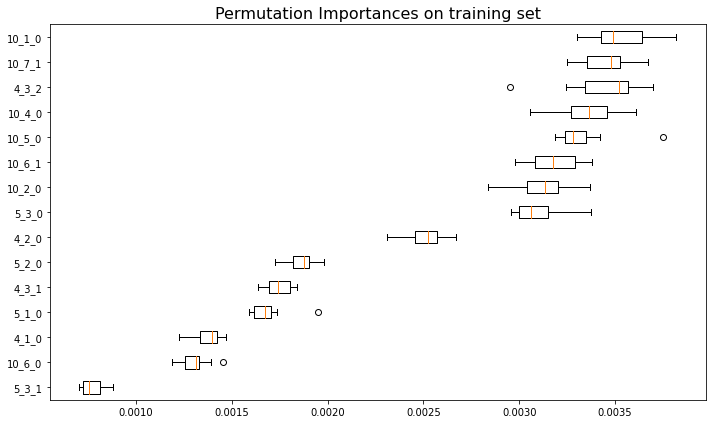

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

ntop = 15
sorted_idx = result_trainset.importances_mean.argsort()
ax.boxplot(result_trainset.importances[sorted_idx][:ntop].T,
           vert=False, labels=ts_pf.columns[sorted_idx][::-1][:ntop])
ax.set_title("Permutation Importances on training set", fontsize=16)
fig.tight_layout()
plt.show()

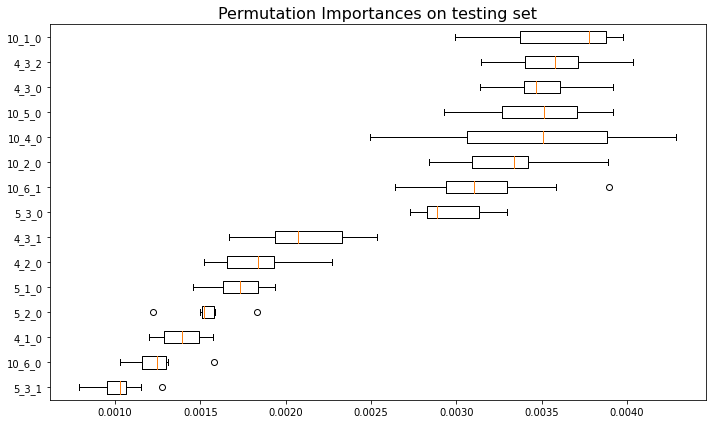

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

ntop = 15
sorted_idx = result_testset.importances_mean.argsort()
ax.boxplot(result_testset.importances[sorted_idx][:ntop].T,
           vert=False, labels=ts_pf.columns[sorted_idx][::-1][:ntop])
ax.set_title("Permutation Importances on testing set", fontsize=16)
fig.tight_layout()
plt.show()

# References: 

1. https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
2. https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
